## 1. Import thư viện

In [37]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#importing libraries for KNN
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [38]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2. Load dữ liệu

In [47]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Public Dataset/NSE-TATAGLOBAL.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


Có nhiều biến trong tập dữ liệu - ngày, mở, cao, thấp, cuối cùng, đóng, tổng_thể_tính_quảng, và doanh thu.

* Các cột Open và Close đại diện cho giá khởi điểm và giá cuối cùng mà cổ phiếu được giao dịch vào một ngày cụ thể.
* High , Lowand Last và Cuối cùng đại diện cho giá tối đa, tối thiểu và cuối cùng của cổ phiếu trong ngày.
* Total Trade Quantity là số lượng cổ phiếu được mua hoặc bán trong ngày và Turnover (Lacs) là doanh thu của một công ty cụ thể vào một ngày nhất định.

Một điều quan trọng cần lưu ý là chợ đóng cửa vào cuối tuần và ngày lễ. Lưu ý lại bảng trên, một số giá trị ngày bị thiếu - 2/10/2018, 6/10/2018, 7/10/2018. Trong số những ngày này, ngày thứ 2 là ngày nghỉ lễ quốc gia trong khi ngày thứ 6 và thứ 7 rơi vào cuối tuần.

Việc tính toán lãi hoặc lỗ thường được xác định bởi giá đóng cửa của một cổ phiếu trong ngày, do đó chúng tôi sẽ coi giá đóng cửa là biến mục tiêu. Hãy vẽ biểu đồ của biến mục tiêu để hiểu cách nó hình thành trong dữ liệu của chúng ta:

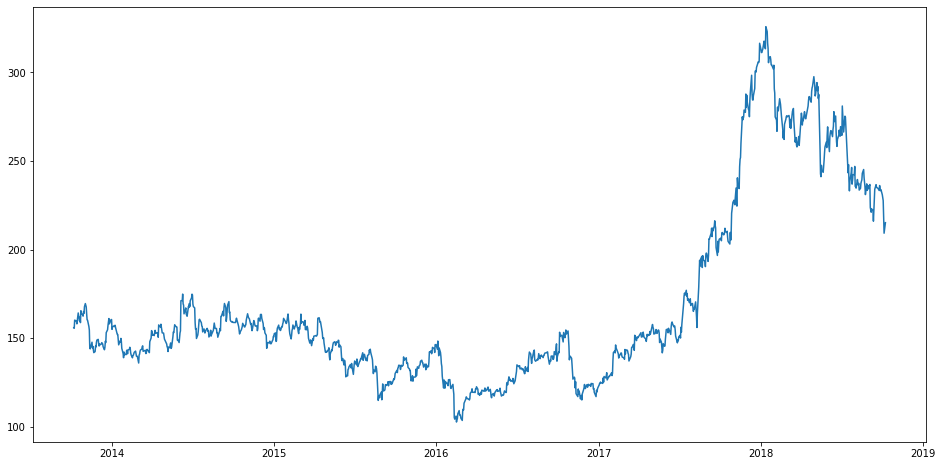

In [48]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

# 3. Pre-Processing

In [49]:
#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#create features
from fastai.tabular import  add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())
/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:64: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df[prefix + 'Elapsed'] = field.astype(np.int64) // 10 ** 9


Create Features: 
* ‘Year’, 
* ‘Month’
* ‘Week’ 
* ‘Day’ 
* ‘Dayofweek’
* ‘Dayofyear’
* ‘Is_month_end’
* ‘Is_month_start’
* ‘Is_quarter_end’
* ‘Is_quarter_start’
*  ‘Is_year_end’
* ‘Is_year_start’.

Cho rằng ngày đầu tiên và cuối tuần có khả năng ảnh hưởng đến giá đóng cửa của cổ phiếu nhiều hơn những ngày khác. Vì vậy, tôi đã tạo một tính năng xác định xem một ngày nhất định là Thứ Hai / Thứ Sáu hay Thứ Ba / Thứ Tư / Thứ Năm. 

In [50]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Chia dữ liệu thành các tập xác nhận và đào tạo để kiểm tra hiệu suất của mô hình.

In [51]:
#split into train and validation
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

# 4. Implementation

### Linear Regression

In [52]:
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

#make predictions
preds = model.predict(x_valid)

#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

121.16291596522808

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


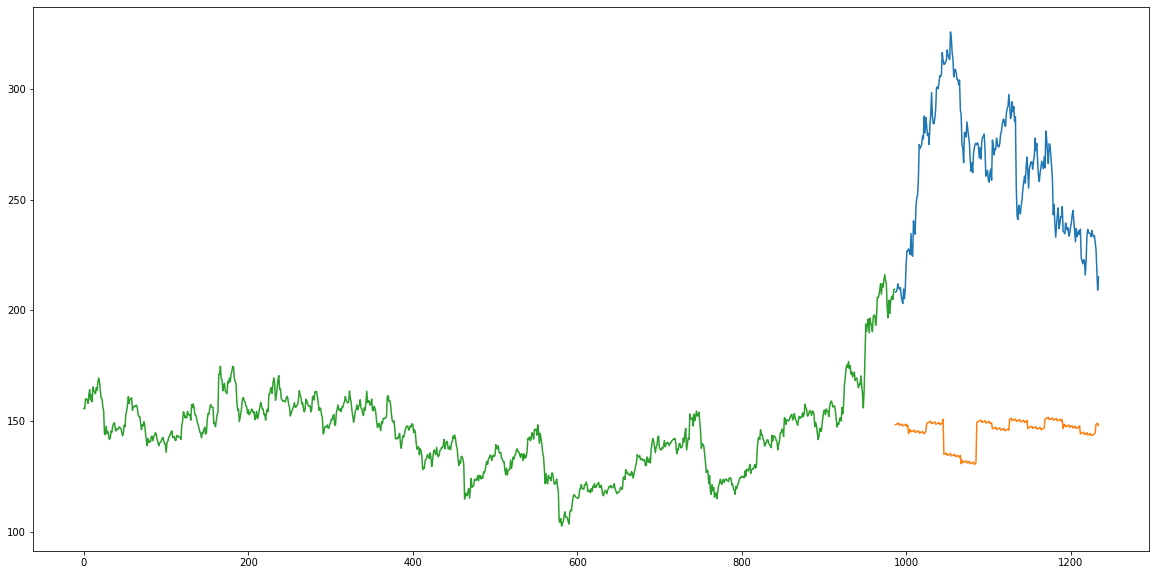

In [53]:
valid ['Predictions'] = 0 
valid ['Predictions'] = preds 
plt.plot (valid [['Close', 'Predictions']]) 
plt.plot (train ['Close'])

Hồi quy tuyến tính là một kỹ thuật đơn giản và khá dễ hiểu, nhưng có một vài nhược điểm rõ ràng. Một vấn đề trong việc sử dụng các thuật toán hồi quy là mô hình quá phù hợp với cột ngày và tháng. 

Thay vì tính đến các giá trị trước đó từ điểm dự đoán, mô hình sẽ xem xét giá trị từ cùng một ngày một tháng trước hoặc cùng một ngày / tháng một năm trước.

Như đã thấy từ biểu đồ trên, vào tháng 1 năm 2016 và tháng 1 năm 2017, giá cổ phiếu đã giảm. Mô hình đã dự đoán tương tự cho tháng 1 năm 2018. 

### KNN (K-Nearest Neighbours)

In [54]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

115.17086550026721

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


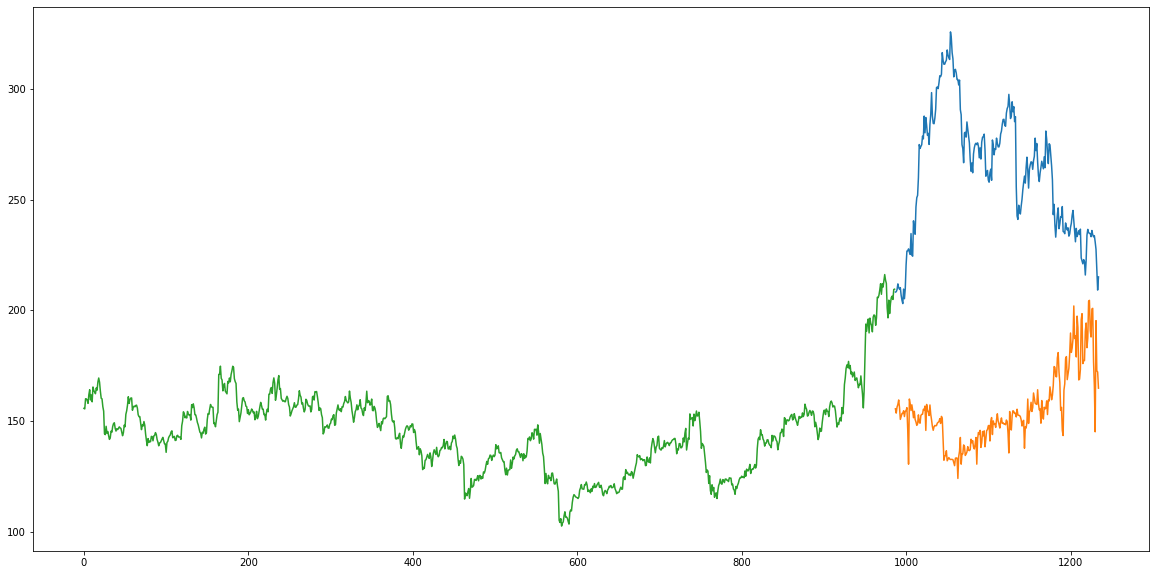

In [55]:
valid ['Predictions'] = 0 
valid ['Predictions'] = preds 
plt.plot (valid [['Close', 'Predictions']]) 
plt.plot (train ['Close'])

Giá trị RMSE gần như tương tự với mô hình hồi quy tuyến tính. Giống như hồi quy tuyến tính, KNN cũng xác định sự sụt giảm trong tháng 1 năm 2018 vì đó là mô hình trong những năm qua. Chúng ta có thể nói một cách an toàn rằng các thuật toán hồi quy không hoạt động tốt trên tập dữ liệu này.

### Auto ARIMA

In [ ]:
pip install pmdarima

In [61]:
from pmdarima.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:987]
valid = data[987:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=248)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=10.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5477.259, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5168.276, Time=1.69 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=7.99 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5479.164, Time=0.46 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5076.280, Time=3.55 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=13.91 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.77 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5074.398, Time=0.78 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5166.277, Time=0.35 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=4.97 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5076.285, Time=1.11 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5077.935, Time=2.37 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5076

54.54322744872866

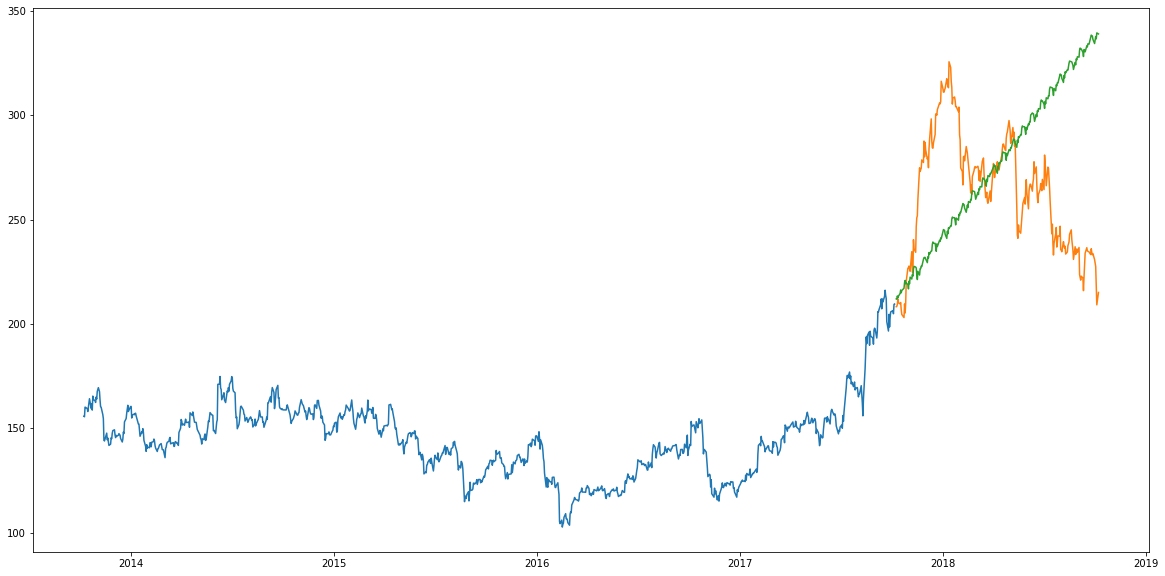

In [62]:
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

mô hình ARIMA tự động sử dụng dữ liệu trong quá khứ để hiểu mô hình trong chuỗi thời gian. Sử dụng các giá trị này, mô hình nắm bắt được xu hướng ngày càng tăng trong chuỗi. Mặc dù các dự đoán sử dụng kỹ thuật này tốt hơn nhiều so với các dự đoán của các mô hình học máy đã triển khai trước đó, nhưng những dự đoán này vẫn không gần với giá trị thực.

### Prophet

In [64]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:987]
valid = new_data[987:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

#rmse
forecast_valid = forecast['yhat'][987:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


57.31515213754124

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


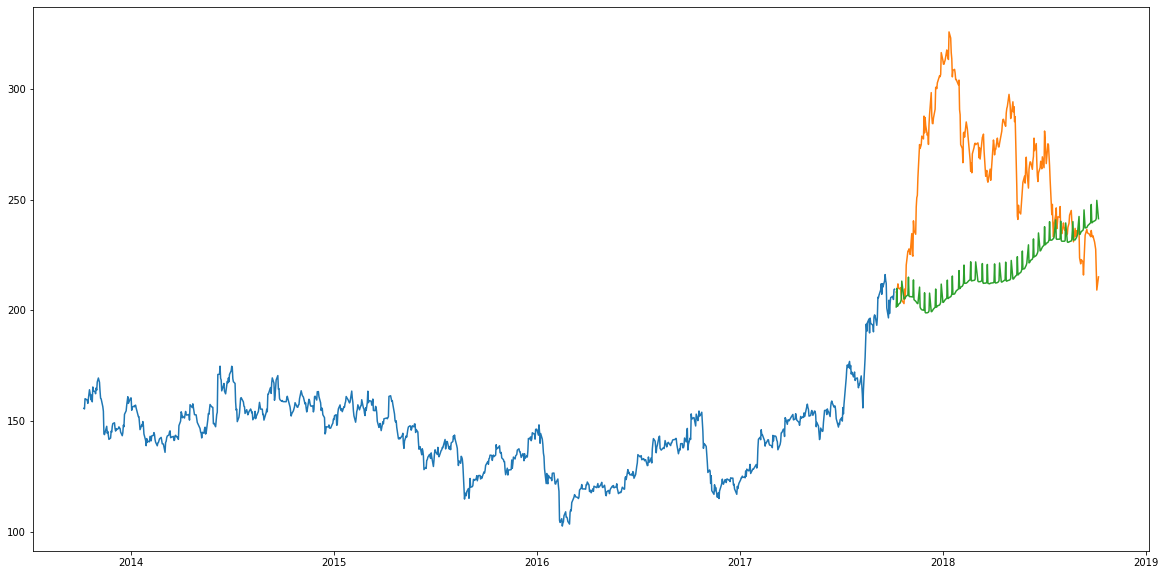

In [65]:
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

Prophet (giống như hầu hết các kỹ thuật dự báo chuỗi thời gian) cố gắng nắm bắt xu hướng và tính thời vụ từ dữ liệu trong quá khứ. Mô hình này thường hoạt động tốt trên tập dữ liệu chuỗi thời gian, nhưng không đạt được hiệu quảntrong trường hợp này.

Giá cổ phiếu không có một xu hướng hoặc tính thời vụ cụ thể. Nó phụ thuộc nhiều vào những gì hiện đang diễn ra trên thị trường và do đó giá cả lên xuống. Do đó, các kỹ thuật dự báo như ARIMA, SARIMA và Prophet sẽ không cho kết quả tốt.

### LSTM - Long Short Term Memory

In [66]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

# rmse
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

927/927 - 36s - loss: 0.0011 - 36s/epoch - 39ms/step


11.348756480492922

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


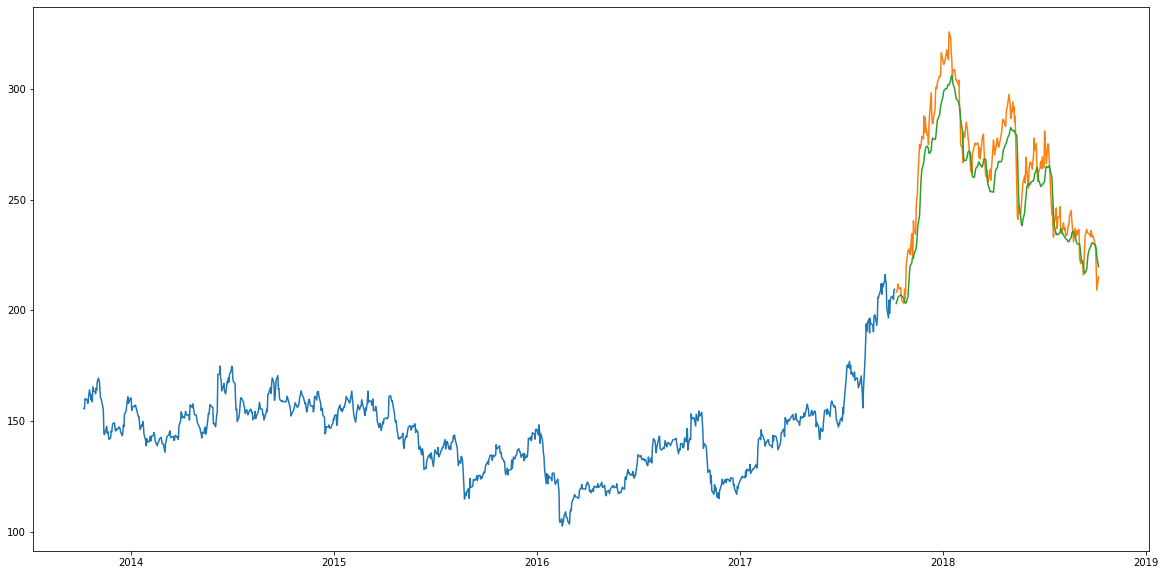

In [67]:
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

Mô hình LSTM có thể được điều chỉnh cho các tham số khác nhau như thay đổi số lượng lớp LSTM, thêm giá trị bỏ qua hoặc tăng số kỷ epochs. Nhưng những dự đoán từ LSTM có đủ để nhận định giá cổ phiếu sẽ tăng hay giảm? Chắc chắn là không rồi!

Giá cổ phiếu bị ảnh hưởng bởi tin tức về công ty và các yếu tố khác như hủy kiếm tiền hoặc sáp nhập / tách công ty. Có một số yếu tố vô hình nhất định thường không thể dự đoán trước.